# Learning tensors for General Relativity

In [1]:

from sympy import *
from sympy.tensor.tensor import TensorIndexType, TensorIndex, TensorHead, tensor_indices, tensor_heads
from sympy.tensor.toperators import PartialDerivative
init_printing()
import sys
print(sys.version)

3.9.19 (main, May  6 2024, 19:43:03) 
[GCC 11.2.0]


## Christoffel symbols for 2D sphere

## Declare a class to model geometry for given particular geometry

2-sphere


'Metric:'

'Gamma:'

⎡                     ⎡        cos(θ)⎤⎤
⎢                     ⎢  0     ──────⎥⎥
⎢⎡0        0       ⎤  ⎢        sin(θ)⎥⎥
⎢⎢                 ⎥  ⎢              ⎥⎥
⎢⎣0  -sin(θ)⋅cos(θ)⎦  ⎢cos(θ)        ⎥⎥
⎢                     ⎢──────    0   ⎥⎥
⎣                     ⎣sin(θ)        ⎦⎦

'Expression:'

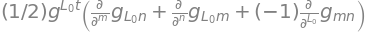

'Riemann curvature expression:'

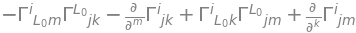

'Riemann curvature result:'

⎡         ⎡             2   ⎤⎤
⎢⎡0  0⎤   ⎢   0      sin (θ)⎥⎥
⎢⎢    ⎥   ⎢                 ⎥⎥
⎢⎣0  0⎦   ⎢    2            ⎥⎥
⎢         ⎣-sin (θ)     0   ⎦⎥
⎢                            ⎥
⎢⎡0  -1⎤        ⎡0  0⎤       ⎥
⎢⎢     ⎥        ⎢    ⎥       ⎥
⎣⎣1  0 ⎦        ⎣0  0⎦       ⎦

polar_plane


'Metric:'

'Gamma:'

⎡         ⎡   1⎤⎤
⎢         ⎢0  ─⎥⎥
⎢⎡0  0 ⎤  ⎢   R⎥⎥
⎢⎢     ⎥  ⎢    ⎥⎥
⎢⎣0  -R⎦  ⎢1   ⎥⎥
⎢         ⎢─  0⎥⎥
⎣         ⎣R   ⎦⎦

'Expression:'

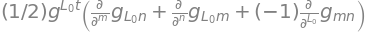

'Riemann curvature expression:'

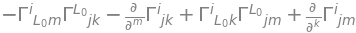

'Riemann curvature result:'

⎡⎡0  0⎤  ⎡0  0⎤⎤
⎢⎢    ⎥  ⎢    ⎥⎥
⎢⎣0  0⎦  ⎣0  0⎦⎥
⎢              ⎥
⎢⎡0  0⎤  ⎡0  0⎤⎥
⎢⎢    ⎥  ⎢    ⎥⎥
⎣⎣0  0⎦  ⎣0  0⎦⎦

3-sphere


'Metric:'

'Gamma:'

⎡                                             ⎡             1   ⎤⎤
⎢                     ⎡   1                ⎤  ⎢0    0       ─   ⎥⎥
⎢⎡0  0       0     ⎤  ⎢0  ─        0       ⎥  ⎢             R   ⎥⎥
⎢⎢                 ⎥  ⎢   R                ⎥  ⎢                 ⎥⎥
⎢⎢0  -R      0     ⎥  ⎢                    ⎥  ⎢           cos(θ)⎥⎥
⎢⎢                 ⎥  ⎢1                   ⎥  ⎢0    0     ──────⎥⎥
⎢⎢             2   ⎥  ⎢─  0        0       ⎥  ⎢           sin(θ)⎥⎥
⎢⎣0  0   -R⋅sin (θ)⎦  ⎢R                   ⎥  ⎢                 ⎥⎥
⎢                     ⎢                    ⎥  ⎢1  cos(θ)        ⎥⎥
⎢                     ⎣0  0  -sin(θ)⋅cos(θ)⎦  ⎢─  ──────    0   ⎥⎥
⎣                                             ⎣R  sin(θ)        ⎦⎦

'Expression:'

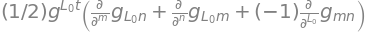

'Riemann curvature expression:'

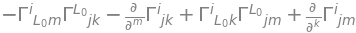

'Riemann curvature result:'

⎡⎡0  0  0⎤  ⎡0  0  0⎤  ⎡0  0  0⎤⎤
⎢⎢       ⎥  ⎢       ⎥  ⎢       ⎥⎥
⎢⎢0  0  0⎥  ⎢0  0  0⎥  ⎢0  0  0⎥⎥
⎢⎢       ⎥  ⎢       ⎥  ⎢       ⎥⎥
⎢⎣0  0  0⎦  ⎣0  0  0⎦  ⎣0  0  0⎦⎥
⎢                               ⎥
⎢⎡0  0  0⎤  ⎡0  0  0⎤  ⎡0  0  0⎤⎥
⎢⎢       ⎥  ⎢       ⎥  ⎢       ⎥⎥
⎢⎢0  0  0⎥  ⎢0  0  0⎥  ⎢0  0  0⎥⎥
⎢⎢       ⎥  ⎢       ⎥  ⎢       ⎥⎥
⎢⎣0  0  0⎦  ⎣0  0  0⎦  ⎣0  0  0⎦⎥
⎢                               ⎥
⎢⎡0  0  0⎤  ⎡0  0  0⎤  ⎡0  0  0⎤⎥
⎢⎢       ⎥  ⎢       ⎥  ⎢       ⎥⎥
⎢⎢0  0  0⎥  ⎢0  0  0⎥  ⎢0  0  0⎥⎥
⎢⎢       ⎥  ⎢       ⎥  ⎢       ⎥⎥
⎣⎣0  0  0⎦  ⎣0  0  0⎦  ⎣0  0  0⎦⎦

In [2]:
class Geometry:
    def __init__(self, which_geometry):
        self.which_geometry = which_geometry

        self.fMetric = None
        self.fX = None
        self.fGamma = None
        self.fGamma_expr = None
        self.fRiemann = None

        self.L = TensorIndexType('L', dummy_name='L')
        self.x = tensor_heads('_', [self.L])
    
    def metric(self):
        if self.fMetric is None:
            theta, phi, R = symbols('theta phi R')
            cases = {
                '2-sphere': ([[1,0],[0,sin(theta)**2]], [theta, phi]),
                'polar_plane': ([[1, 0],[0, R**2]], [R, theta]),
                '3-sphere': ([[1,0,0], [0, R**2, 0], [0,0,R**2 * sin(theta)**2]], [R, theta, phi])
            }
            self.fMetric, self.fX = cases[self.which_geometry]
        return self.fMetric

    def gamma(self):
        """ The Christoffel symbols """
        if self.fGamma is None:
            L = self.L
            g = tensor_heads('g', [L, L])
            m,n,t,q = tensor_indices('m n t q', L)
            x_repl = {self.x(q): self.fX}
            metric_repl = {L: self.metric(), g(-m,-n):self.metric()}
            gamma = tensor_heads('Gamma', [L, L, L])
            gamma_repl = {gamma(-m, -n, t):self.gamma_expr().replace_with_arrays(x_repl | metric_repl)}
            self.fGamma = gamma(-m, -n, t).replace_with_arrays(gamma_repl)
            
        return self.fGamma

    def gamma_expr(self):
        if self.fGamma_expr is None:
            L = self.L
            m, n, r, t = tensor_indices('m n r t', L)
            x = self.x
            g = tensor_heads('g', [L, L])
            self.fGamma_expr = g(r,t) / 2 * (
                PartialDerivative(g(-r, -m), x(n)) + 
                PartialDerivative(g(-r, -n), x(m)) - 
                PartialDerivative(g(-m, -n), x(r)))
        return self.fGamma_expr

    def riemann_curvature(self):
        L = self.L
        i, j, k, m, n, q, r  = tensor_indices('i j k m n q r', L)
        x_repl = {self.x(q): self.fX}
        gamma = tensor_heads('Gamma', [L, L, L])
        R_exp = (
            PartialDerivative(gamma(i, -j, -m), self.x(k)) - 
            PartialDerivative(gamma(i, -j, -k), self.x(m)) + 
            gamma(i, -r, -k) * gamma(r, -j, -m) - 
            gamma(i, -r, -m) * gamma(r, -j, -k))
        
        R = tensor_heads('R', [L, L, L, L])
        gamma_repl = {gamma(i, -j, -m) : self.gamma()}
        R_repl = {R(i, -k, -m, -j): R_exp.replace_with_arrays(x_repl | gamma_repl)}  # swapping final two indices, seems necessary
        result = R(i, -k, -j, -m).replace_with_arrays(R_repl)
    
        return R_exp, result

def test_geometry(): 

    for which in '2-sphere', 'polar_plane', '3-sphere':
        print(which)
        geom = Geometry(which)
        display ('Metric:', geom.metric())

        display ('Gamma:', geom.gamma())
        display ('Expression:', geom.gamma_expr())

        r_exp, r_result = geom.riemann_curvature()
        display ('Riemann curvature expression:', r_exp)
        display ('Riemann curvature result:', r_result)
        

   
test_geometry()

